<a href="https://colab.research.google.com/github/kushal19057/nlp-project/blob/main/BERT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.2 MB/s 
     |████████████████████████████████| 182 kB 75.3 MB/s 
     |████████████████████████████████| 7.6 MB 61.1 MB/s 


In [31]:
import pandas as pd
import numpy as np
import math
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP/H1_Offensive_Language_Identification_train.csv")

In [5]:
df_train.head()

,tweet,label,id
0,@USER She should ask a few native Americans wh...,OFF,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,Amazon is investigating Chinese employees who ...,NOT,2
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4


In [6]:
print(np.sum(df_train["label"] == "NOT"))
print(np.sum(df_train["label"] == "OFF"))

8840
4400


In [7]:
tweets = list(df_train["tweet"])
tweets[:15]

['@USER She should ask a few native Americans what their take on this is.',
 '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
 'Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
 '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
 '@USER @USER Obama wanted liberals &amp; illegals to move into red states',
 '@USER Liberals are all Kookoo !!!',
 '@USER @USER Oh noes! Tough shit.',
 '@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism',
 '@USER Buy more icecream!!!',
 '@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo',
 '@USER @USER @USER It’s not my fault you support gun control',
 '@USER What’s the diff

###Pre_Processing

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
!pip install unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 14.5 MB/s 


In [10]:
!pip install demoji
import demoji
import re,string
import unidecode
import random

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    # text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    # text = [word for word in text.split() if word not in stop_words]
    # text = ' '.join(text)
    # text =' '.join(word for word in text.split() if len(word) < 50) # remove words longer than 14 characters
    return text

#remove multispace sequences
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'s ", " is ", text)
    text = re.sub(r"\'d ", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'t", " not ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'m", " am ", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

def preprocessing(tweets):
  clean_tweets = []
  for tweet in tweets:
    
    #cleaning emojis
    if demoji.findall(tweet):
      tweet = demoji.replace_with_desc(tweet,sep=" ")
    #cleaning @USER
    tweet = re.sub(r'@USER',' ',tweet)
    #cleaning URL
    tweet = re.sub(r'URL',' ',tweet)
    #cleaning &amp,&lt,&gt
    tweet = re.sub(r'&[a-zA-Z]+', ' ', tweet)
    #cleaning stopwords,links,punctuations
    # tweet = tweet.lower()
    # tweet = decontract(tweet)
    tweet = clean_hashtags(tweet)
    tweet = strip_all_entities(tweet)
    tweet = remove_mult_spaces(tweet)
    

    clean_tweets.append(tweet)  

  return clean_tweets




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.5 MB/s 


In [11]:
clean_tweets = preprocessing(tweets)
clean_tweets[:15]

['she should ask a few native americans what their take on this is.',
 'go home you’re drunk!!! maga trump2020 oncoming fist flag: united states oncoming fist',
 'amazon is investigating chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace.',
 'someone should\'vetaken" this piece of shit to a volcano. face with tears of joy "',
 'obama wanted liberals ; illegals to move into red states',
 'liberals are all kookoo !!!',
 'oh noes! tough shit.',
 'was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism',
 'buy more icecream!!!',
 'canada doesn’t need another cuck! we already have enough looneyleft liberals f**king up our great country!',
 'it’s not my fault you support gun control',
 'what’s the difference between kavanaugh and one of these men admitted to groping a 15 year old girl years ago. the other is 

In [12]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 15.2 MB/s 
     |████████████████████████████████| 212 kB 73.0 MB/s 
     |████████████████████████████████| 132 kB 68.9 MB/s 
     |████████████████████████████████| 127 kB 80.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [13]:
df_train["clean_tweets"] = clean_tweets


In [ ]:
clean_tweets_tokens = [sent.split(' ') for sent in clean_tweets]
len_arr = [len(sent) for sent in clean_tweets_tokens]
len_arr = sorted(len_arr)
print(len_arr)
print(np.mean(len_arr))
print(np.min(len_arr))
print(np.max(len_arr))
print(np.median(len_arr))

In [15]:
#Encoding the labels
df_train['labels'] = df_train["label"].map({'OFF':0,'NOT':1})

In [16]:
df_train.head()

,tweet,label,id,clean_tweets,labels
0,@USER She should ask a few native Americans wh...,OFF,0,she should ask a few native americans what the...,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,go home you’re drunk!!! maga trump2020 oncomin...,0
2,Amazon is investigating Chinese employees who ...,NOT,2,amazon is investigating chinese employees who ...,1
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3,"someone should'vetaken"" this piece of shit to ...",0
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4,obama wanted liberals ; illegals to move into ...,1


In [17]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
import copy
df_train_copy = copy.deepcopy(df_train)
df_train = df_train_copy
display(df_train_copy.head())
df_train = df_train.drop(['tweet','label','id'],axis = 1)
display(df_train)
train_df,val_df = train_test_split(df_train,test_size=0.3)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)


,tweet,label,id,clean_tweets,labels
0,@USER She should ask a few native Americans wh...,OFF,0,she should ask a few native americans what the...,0
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,go home you’re drunk!!! maga trump2020 oncomin...,0
2,Amazon is investigating Chinese employees who ...,NOT,2,amazon is investigating chinese employees who ...,1
3,"@USER Someone should'veTaken"" this piece of sh...",OFF,3,"someone should'vetaken"" this piece of shit to ...",0
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,4,obama wanted liberals ; illegals to move into ...,1


,clean_tweets,labels
0,she should ask a few native americans what the...,0
1,go home you’re drunk!!! maga trump2020 oncomin...,0
2,amazon is investigating chinese employees who ...,1
3,"someone should'vetaken"" this piece of shit to ...",0
4,obama wanted liberals ; illegals to move into ...,1
...,...,...
13235,sometimes i get strong vibes from people and t...,0
13236,benidorm check mark button creamfields check m...,1
13237,and why report this garbage. we don't give a c...,0
13238,pussy,0


### DataSet Formation

In [18]:
class GPReviewDataset(Dataset):

  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self, item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      tweets,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation = True,
      return_tensors='pt',
    )

    return {
      'tweets': tweets,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(labels, dtype=torch.long)
    }

In [19]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    tweets=df.clean_tweets.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [20]:
from transformers import RobertaTokenizer,RobertaModel
from transformers import AutoTokenizer,AutoModel
BATCH_SIZE = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
# model2 = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

MAX_LEN = 50

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweets', 'input_ids', 'attention_mask', 'labels'])

In [22]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


### Model Initialization 

In [32]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes,freeze_bert = False
               ,filter_sizes=[1,2,3,4,5],
                num_filters=[32,32,32,32,32]):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)
    # self.roberta = RobertaModel.from_pretrained('roberta-base')

    self.conv1d_list = nn.ModuleList([
        nn.Conv1d(in_channels = 3072,
                  out_channels = num_filters[i],
                  kernel_size = filter_sizes[i])
        for i in range(len(filter_sizes))
    ])
    self.fc = nn.Linear(np.sum(num_filters),2)
    self.dropout = nn.Dropout(0.3)
    self.Softmax = nn.Softmax()
    
    
    if freeze_bert:
        for param in self.roberta.parameters():
            param.requires_grad = False
  
  def mean_pooling(self,token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool
  def forward(self, input_ids, attention_mask):
    m_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    m_hs = m_output['hidden_states'] 
    pooled_output_1 = m_hs[12]
    pooled_output_2 = m_hs[11]
    pooled_output_3 = m_hs[10]
    pooled_output_4 = m_hs[9]
    pooled_output = torch.cat(
        (pooled_output_1,pooled_output_2,pooled_output_3,pooled_output_4),dim = -1)
    pooled_output = pooled_output.permute(0,2,1)

    output_conv_list = [F.gelu(conv1d(pooled_output)) for conv1d in self.conv1d_list]
    output_pool_list = [F.max_pool1d(output_conv,kernel_size = output_conv.shape[2])
                       for output_conv in output_conv_list]
    output_fc = torch.cat([output_pool.squeeze(dim=2) for output_pool in output_pool_list],dim = 1)
    logits = self.fc(self.dropout(output_fc))
    return self.Softmax(logits)
    

In [24]:
model = SentimentClassifier(2)
model(data['input_ids'],data['attention_mask'])

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-23-272a19f6829e>:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument

tensor([[0.5087, 0.4913],
        [0.4240, 0.5760],
        [0.5759, 0.4241],
        [0.4644, 0.5356],
        [0.5003, 0.4997],
        [0.4467, 0.5533],
        [0.5731, 0.4269],
        [0.4905, 0.5095],
        [0.3076, 0.6924],
        [0.4628, 0.5372],
        [0.3003, 0.6997],
        [0.3073, 0.6927],
        [0.4639, 0.5361],
        [0.4390, 0.5610],
        [0.4217, 0.5783],
        [0.2396, 0.7604]], grad_fn=<SoftmaxBackward0>)

In [65]:
model = SentimentClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

In [66]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=5e-5,    # Default learning rate
                      eps=1e-8)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [67]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  true_labels = []
  pred_labels = []
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    _, preds = torch.max(outputs, dim=1)
    
   

    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    pred_labels.extend(list(torch.detach(preds).cpu().numpy()))
    true_labels.extend(list(torch.detach(labels).cpu().numpy()))
    
  p,r,f,n = precision_recall_fscore_support(true_labels,pred_labels, average='macro')
  print(f'F1-Score {f}:  Recall {r}:   Precision{p}')
  return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0
  pred_labels= []
  true_labels = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      pred_labels.extend(list(torch.detach(preds).cpu().numpy()))
      true_labels.extend(list(torch.detach(labels).cpu().numpy()))
    
  p,r,f,n = precision_recall_fscore_support(true_labels,pred_labels, average='macro')
  print(f'F1-Score {f}:  Recall {r}:   Precision{p}')
  
  return correct_predictions.double() / n_examples, np.mean(losses)  

In [68]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val_df)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/NLP/CNN_BERT.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7100718564241674:  Recall 0.6986734722860155:   Precision0.7392407407407408
Train loss 0.5432908678876942 accuracy 0.5330060422960725


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7318904416786574:  Recall 0.7130564542840789:   Precision0.8002851302351615
Val   loss 0.5170131729070442 accuracy 0.7933031218529708

Epoch 2/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7855766852195424:  Recall 0.7728675542092311:   Precision0.8082324628889392
Train loss 0.49008289868461674 accuracy 0.5734138972809668


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7658132347964071:  Recall 0.759142306511335:   Precision0.7749594512731324
Val   loss 0.5115471353013832 accuracy 0.7993454179254783

Epoch 3/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.8233296158521368:  Recall 0.8167359923622736:   Precision0.8317607052097665
Train loss 0.4634387644714323 accuracy 0.5922960725075529


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7662004922282658:  Recall 0.7684879960149308:   Precision0.764150494672755
Val   loss 0.5174203924385898 accuracy 0.7922960725075529

Epoch 4/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.860310824004526:  Recall 0.8538940369021826:   Precision0.868171524321797
Train loss 0.43360512051089056 accuracy 0.6145770392749245


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7632989617497012:  Recall 0.7668528744556429:   Precision0.7603130810898213
Val   loss 0.5198839787977287 accuracy 0.7887713997985901

Epoch 5/5
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.8802000355203261:  Recall 0.8727256911398116:   Precision0.8894900957738583
Train loss 0.4168118175761453 accuracy 0.6268882175226587


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-32-4f4e5e0c5ee0>:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.Softmax(logits)


F1-Score 0.7671609258360758:  Recall 0.7600683574049971:   Precision0.7770546181390101
Val   loss 0.5090245290932406 accuracy 0.8008559919436052

CPU times: user 7min 50s, sys: 1min 53s, total: 9min 43s
Wall time: 9min 58s


### Graph

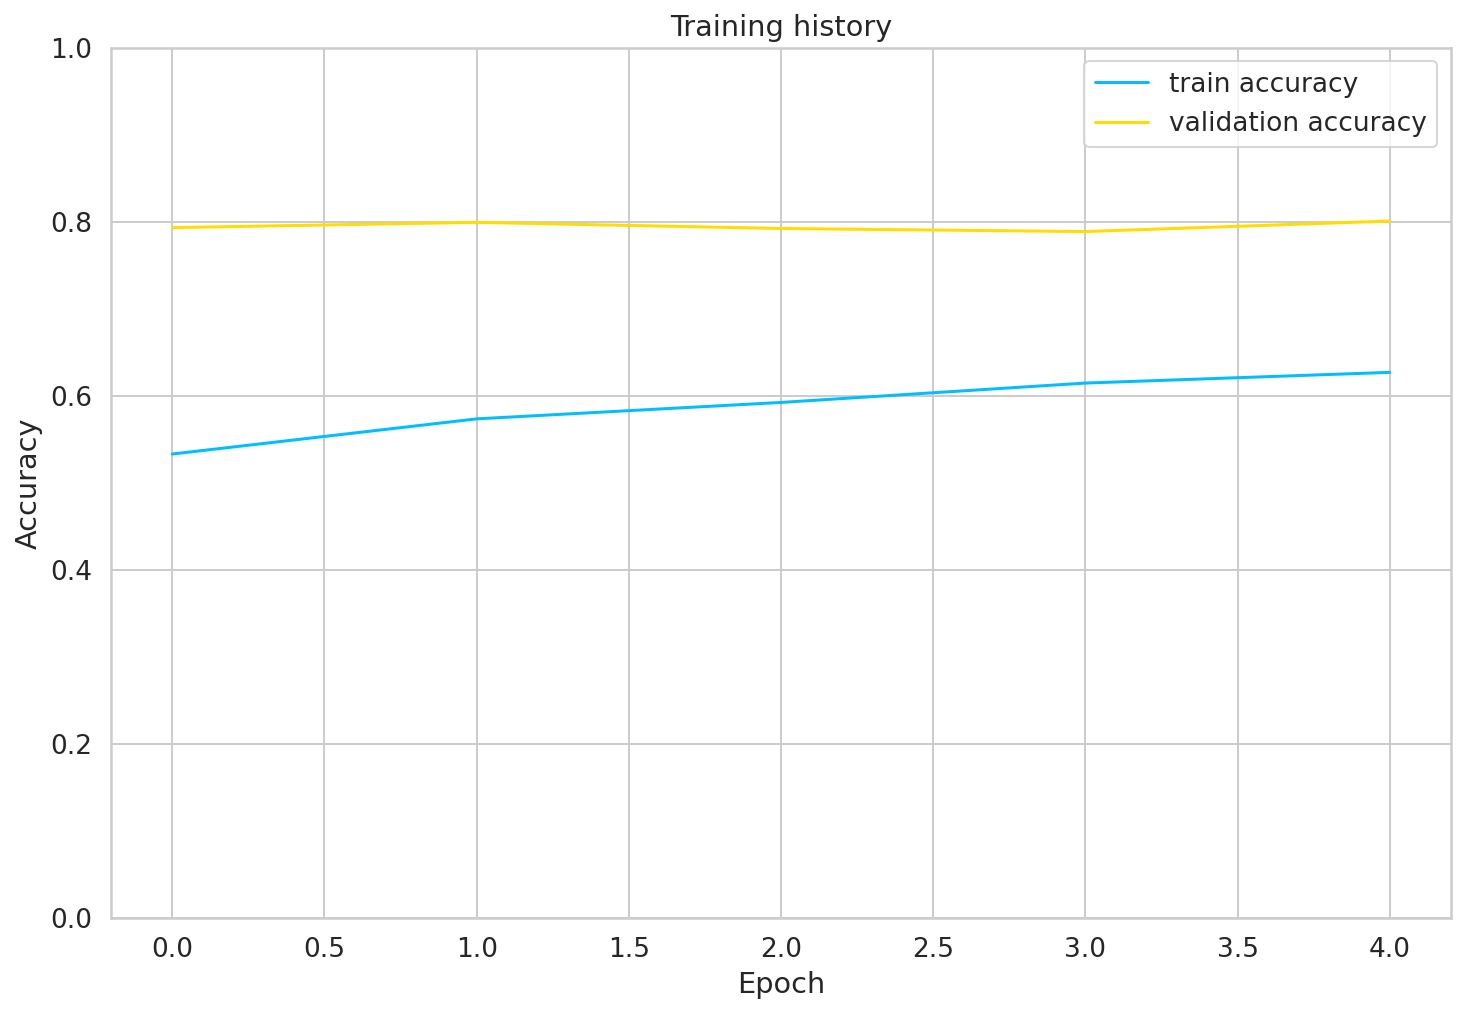

In [85]:
tl= list(map(lambda x:(torch.detach(x).cpu()).tolist(),history['train_acc']))
vl = list(map(lambda x:(torch.detach(x).cpu()).tolist(),history['val_acc']))
plt.plot(tl, label='train accuracy')
plt.plot(vl, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);